<a href="https://colab.research.google.com/github/MrEktirir/Antibiotics-Resistance-Prediction/blob/feature%2FCreating_Resistance_Models/Notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install CatBoost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.0 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import time
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import cm
from tqdm import tqdm
!pip install biopython
from Bio.Seq import Seq

# Sklearn Module
from sklearn.model_selection import KFold,GroupKFold,GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve,ShuffleSplit
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN

# Machine Learning Models
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from catboost import CatBoostClassifier,CatBoostRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import os,warnings;warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Files

In [4]:
azm_sr_df = pd.read_csv('/content/drive/MyDrive/Dataset/azm_sr_gwas_filtered_unitigs.Rtab', sep="\t")
cfx_sr_df = pd.read_csv('/content/drive/MyDrive/Dataset/cfx_sr_gwas_filtered_unitigs.Rtab', sep="\t")
cip_sr_df = pd.read_csv('/content/drive/MyDrive/Dataset/cip_sr_gwas_filtered_unitigs.Rtab', sep="\t")
metadata_df = pd.read_csv('/content/drive/MyDrive/Dataset/metadata.csv')

# Basic Stats

# **1. Introduction**

## 1.1 Background

RESISTANCE OF BACTERIA

  We will be focussing on a species called Neisseria gonorrhoeae, the bacteria which cause gonorrhoea.
Gonorrhoea is the second most common sexually transmitted infection (STI) in Europe, after chlamydia.
Rates of gonorrhoea infection are on the rise, with a 26% increase reported from 2017-2018 in the UK.

  Many people who are infected (especially women) experience no symptoms, helping the disease to spread.
If the infection is left untreated, it can lead to infertility in women, and can occasionally spread to
other parts of the body such as your joints, heart valves, brain or spinal cord.
Resistance of these bacteria to antibiotics is rising over time, making infections hard to treat.

* In the past, patients were treated with an antibiotic called ciprofloxaxcin.
* Doctors had to stop using this antibiotic because resistance to the drug became too common, causing treatments of infections to fail.
* Until very recently, the recommended treatment was two drugs - ceftriaxone and azithromycin.
* Azithromycin was removed from recommendations because of concern over rising resistance to the antibiotic.
* In February 2018, the first ever reported case of resistance to treatment with ceftriaxone and azithromycin, as well as resistance to the last-resort treatment spectinomycin, was reported.
* Currently in the UK, patients are only treated with ceftriaxone.

*ANTIBIOTICS*

Three antibiotics and associated unitigs are used to make a model in this problem.

*Azithromycin* :
* Azithromycin is an antibiotic used to treat various types of infections of the respiratory tract, ear, skin and eye in adults and children. It is also effective in typhoid fever and some sexually transmitted diseases like gonorrhea.

*Ciprofloxacin* :
* Ciprofloxacin is an antibiotic, used in the treatment of bacterial infections. It is also used in treating infections of the urinary tract, nose, throat, skin and soft tissues and lungs (pneumonia). It prevents the bacterial cells from dividing and repairing, thereby killing them.

*Cefixime* :
* Cefixime is an antibiotic medicine used to treat a variety of bacterial infections. It is effective in infections of the respiratory tract (eg. pneumonia), urinary tract, ear, nasal sinus, throat, and some sexually transmitted diseases.

**UNITIGS**

In our dataset, we will come across features data that will convey the presence or absence of a particular nucleotide sequence in the Bacteria's DNA

For this analysis, we're using unitigs, stretches of DNA (in string format) shared by a subset of the strains in our study.
* Unitigs are an efficient but flexible way of representing DNA variation in bacteria.
* The full dataset consists of 584,362 unitigs, which takes a long time to train models on, so for this exercise
* We will be using a set that has been filtered for unitigs associated with resistance.


## 1.2. Target Variables

*Neisseria gonorrhoeae* is either resistant (target=1) to a particular treatment or not resistant (target=0) for a particular.

AVAILABLE UNITIG DATA:

* We will be choosing one of the following antibiotic cases below:

  1.   Bacteria resistance to *Azithromycin; azm_sr*
  2.   Bacteria resistance to *Ciprofloxacin; cip_sr*
  3.   Bacteria resistance to *Cefixime; cfx_sr*

UNAVAILABLE UNITIG DATA:

* We don't currently have unitig data for the following antibiotics, so we can't check these cases:

  1.   Bacteria resistance to *Ceftriaxone; cro_sr*
  2.   Bacteria resistance to *Tetracycline; tet_sr*
  3.   Bacteria reistance to *Penicillin; pen_sr*

# 2. Dataset

## 2.1. Creating Dataset

**GET_UNITIGS CLASS**

  *   We need to do some data wrangling & combine two data files together; `.get_case`
  *   In this problem, a case type format is used (grouped feature matrix & target vector)

The feature matrix (stored within .X) will contain:

  * All collected samples from across various databses, corresponding to the bacteria's DNA (which was cut into segments of 31-mers)

  * When a particular DNA segment (unitig) is present in the bacterial sample DNA, it's value is set to 1 & 0 if it's not present

**MERGING RTAB & METADATA**

  * Filtered Unitig data is located in .Rtab files, corresponding to the same **`sample_id`** as that of the metadata

  * We need read the .Rtab files & merge the two dataframes based on the **`sample_id`** index; using .get_case()



In [5]:
''' Align Metadata Target values Unitig File & Compile Feature Matrix '''

class get_unitigs:

    def __init__(self,verbose=True):
        self.df = pd.read_csv('/content/drive/MyDrive/Dataset/metadata.csv', index_col=0) # metadata
        self.meta_names = self.df.columns
        self.target_name = None
        self.verbose = verbose

    # Get Unitig Feature matrix & Target Vector
    def get_case(self,phenotype=None):

        self.target_name = phenotype
        _metadata = self.df
        if(self.verbose):
            print(f'Target Antibiotic: {self.target_name}')
            print(f'Metadata df: {_metadata.shape}')

        # remove those that don't contain target values
        _metadata = _metadata.dropna(subset=[phenotype])
        self.metadata = _metadata.copy()

        if(self.verbose):
            print(f'Metadata df after na() removal {_metadata.shape}')
        _metadata = _metadata[phenotype] # choose target variable

        prefix = '/content/drive/MyDrive/Dataset/'
        suffix = '_gwas_filtered_unitigs.Rtab'

        if(self.verbose):
            print('\nCombining Metadata & Unitigs')

        # unitig feature matrix for phenotype
        tdf = pd.read_csv(prefix + phenotype + suffix, sep=" ",
                          index_col=0, low_memory=False)
        # align column data w/ metadata df (pattern_id = sample_idd)
        tdf = tdf.T
        # keep only common rows, ie. that have resistence measure]
        tdf = tdf[tdf.index.isin(_metadata.index)]

        train = tdf
        target = _metadata[_metadata.index.isin(tdf.index)]

        self.X = pd.concat([train,target],axis=1)
        if(self.verbose):
            print(f'Unitig Matrix (+target): {self.X.shape}')

In [6]:
metadata_df['Year'] = metadata_df['Year'].fillna(0).astype(np.int64)

In [7]:
for row in metadata_df.Year:
  if row==2008:
    print(row)

2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008
2008


## 2.2 Case Preview - Ciprofloxacin

  We'll be looking at bacterial resistance for three different cases, let's check one case first & load the other when required..
---

**METADATA CONTENT**

* Metadata is stored in .df, which contains our target variable (one of the _sr columns) for a specific Sample_ID

* As we can see, we don't have all the data, some data is missing in our metadata, we'll only be dropping Nan cases for the target variable (_sr) we're concerned with.

**FEATURE MATRIX**

* The feature matrix is created from one of the .Rtab files, depending on which case we are testing.

* Each column in the feature matrix is called a unitig (pattern_id); is treated as a feature for the specific Sample_ID, which is our index.

In [8]:
# Load meta data & look at the first 5 samples
case_cip = get_unitigs()

display(case_cip.df.T.iloc[:,:7])

Sample_ID,ERR1549286,ERR1549290,ERR1549291,ERR1549287,ERR1549288,ERR1549299,ERR1549292
Year,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0
Country,UK,UK,UK,UK,UK,UK,UK
Continent,Europe,Europe,Europe,Europe,Europe,Europe,Europe
Beta.lactamase,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Azithromycin,>256,>256,>256,>256,>256,>256,>256
Ciprofloxacin,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ceftriaxone,0.016,0.004,0.006,0.006,0.008,0.012,0.023
Cefixime,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tetracycline,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Penicillin,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
case_cip.get_case(phenotype='cip_sr')
case_cip.X.iloc[:,:2].head()

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)


,ACGTTTATGCCGTTATCGATCCGATAGCCGGT,CATCTGCACCCTGTCGGCACTCGCCGCCTGAACCACCCCGTCCGGACAAGG
SRR1661154,0,0
SRR1661156,0,0
SRR1661157,0,0
SRR1661158,0,0
SRR1661159,0,0


**TARGET VARIABLE**

* The target vector, is also stored in .X, and represents the resistance property of the sample
* The Sample_ID is either 1.0 (resistant) or 0.0 (non-resistant) to a particular antibiotic in question.

In [10]:
target = case_cip.X[case_cip.target_name]
print(target[:5])

SRR1661154    0.0
SRR1661156    1.0
SRR1661157    0.0
SRR1661158    0.0
SRR1661159    0.0
Name: cip_sr, dtype: float64


## 2.3. Target Variable Distribution

**TARGET DISTRIBUTIONS & UNITIG COUNT**

* It's useful to look at the class distributions for all three cases we'll be making models for.
* As we can see below, the unitig distributions are quite different as well, so our feature matrix will vary significantly for each case.

In [11]:
''' Ciprofloxacin '''

case = get_unitigs()
case.get_case('cip_sr')
print(case.X[case.target_name].value_counts())

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)
cip_sr
0.0    1660
1.0    1428
Name: count, dtype: int64


In [12]:
''' Azithromycin '''

case = get_unitigs()
case.get_case('azm_sr')
print(case.X[case.target_name].value_counts())

Target Antibiotic: azm_sr
Metadata df: (3786, 30)
Metadata df after na() removal (3478, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3478, 516)
azm_sr
0.0    3031
1.0     447
Name: count, dtype: int64


In [13]:
''' Cefixime '''

case = get_unitigs()
case.get_case('cfx_sr')
print(case.X[case.target_name].value_counts())

Target Antibiotic: cfx_sr
Metadata df: (3786, 30)
Metadata df after na() removal (3401, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3401, 385)
cfx_sr
0.0    3396
1.0       5
Name: count, dtype: int64


# 3.Feature Matrix Modification

## 3.1.Creating Case Data

* In Section 2.3, we saw that for some antibiotics, there are very few resistant samples present , mainly Cefixime
* This results in a very tricky situation if we want to use cross validation, we may not even have enough samples for the model to learn anything meaningful
* Creating models Azithromycin & Ciprofloxacin should not have this issue, as we have sufficient number of samples, even if an imbalance is present

We can try two approaches:

* Downsample the dominant class (not resistant) `.split_case`
* Utilise SMOTE based upsampling strategy `smote`

In [14]:
''' Feature Matrix Upsampling Modification (+Target) '''
# Model based approach to upsample minor class in target variable

class mod_unitigs():

    def __init__(self,unitigs):
        self.X = unitigs.X # input data class
        self.target_name = unitigs.target_name
        self.verbose = True

    ''' Downsampling Class 0 using .sample & recompile '''
    # If there's too much of the dominant class, just downsample

    def split_case(self,frac_id=0.5):

        X = self.train
        y = pd.Series(self.target,name=self.target_name)
        XX = pd.concat([X,y],axis=1)

        lst_temp = dict(tuple(XX.groupby(self.target_name))) # divide classes
        ratio = lst_temp[0].shape[0]/lst_temp[1].shape[0] # get class ratio

        # Sample approach for downsizing majority class
        X_red = lst_temp[0].sample(frac=frac_id)
        X_all = pd.concat([X_red,lst_temp[1]],axis=0)

        if(self.verbose):
            print(f'Class 0 : {lst_temp[0].shape}')
            print(f'Class 1 : {lst_temp[1].shape}')
            print(f'Class Ratio: {round(ratio,4)}')
            print(f'Reduced Training Matrix: {X_all.shape}')

        # Redefine .train, .target
        self.target = X_all[self.target_name].copy()
        X_all.drop(self.target_name, inplace=True, axis=1)
        self.train = X_all

    ''' SMOTE UPSAMPLING '''
    # For unbalanced problems, synthetically/model new data

    def smote(self,smote_id = 'smotenc',
                   smote_strat=0.5,
                   k_neighbours=5):

        self.smote_id = smote_id
        self.smote_strat = smote_strat
        self.smote_nbr = k_neighbours

        y = self.X[self.target_name].copy()
        X = self.X.drop([self.target_name],axis=1).copy()

        # smote for contin, smotenc for category
        if(self.smote_id == 'smote'):
            model_id = SMOTE(sampling_strategy=self.smote_strat,
                             k_neighbors=self.smote_nbr)
        elif(self.smote_id == 'smotenc'):
            model_id = SMOTENC(sampling_strategy=self.smote_strat,
                               k_neighbors=self.smote_nbr,
                               categorical_features=[0,1])

        X_mod, y_mod = model_id.fit_resample(X,y)
        self.X = pd.concat([X_mod,y_mod],axis=1)

        if(self.verbose):
            print(f'\nSMOTE Upsampling: {self.X.shape}')
            print(f'Target Value Counts: \n{pd.Series(y_mod).value_counts()}')
        self.X = pd.concat([X_mod,y_mod],axis=1)

# 4.Explotary Data Analysis

## 4.1. Parallel Categories

**EXPLORING THE METADATA**

* Aside from the unitig data, the Metadata Dataset contains some interesting info about each Sample_ID as well.
* Having sorted by the X_mic column, *log2_X_mic* has the same ordering as X_mic & antibiotic column name, so it was not included to reduce clutter in the figures.
* Beta.lactamase relation to antibiotic resistance doesn't seem to exhibit any particular patterns, other than Penicillin, for which the R (resistant) type almost exclsively indicates that the antibiotic will not be effective.
* Most bacteria *Sample_ID* are also shown to be of S (sensitive) type.
* If we highlight the uttermost right column, _sr, we can also note that resistance of these bacteria to antibiotics tends to be rising over time.
* These figures clearly indicate that *cefixime* by far is the most effective treatment out of the tree antibiotics.
* *Ciprofloxacin* on the otherhand has not been very effective treatment against the bacteria.

In [15]:
lst_azm = ['Year','Country','Continent','Beta.lactamase','azm_mic','Azithromycin','azm_sr']
lst_cip = ['Year','Country','Continent','Beta.lactamase','cip_mic','Ciprofloxacin','cip_sr']
lst_cfx = ['Year','Country','Continent','Beta.lactamase','cfx_mic','Cefixime','cfx_sr']
lst_antibio = [lst_azm,lst_cip,lst_cfx]

# Plot Parallel Categories Plot
def plot_pp(lst,colour='ghostwhite'):
    tdf = get_unitigs().df[lst]
    tdf.dropna(inplace=True)
    tdf.sort_values(by=lst[-3],inplace=True,ascending=False)
    tdf['Year'] = tdf['Year'].astype(str)
    fig = px.parallel_categories(tdf)
    fig.update_traces(patch={"line": {"color":colour,'shape':'hspline'}})
    fig.update_layout(title=f'Bacteria Resistance to {lst[-2]}')
    fig.update_layout(margin=dict(t=60,b=10),height=400)
    fig.show()

def plot_geomean(lst):

    global country_map

    tdf = get_unitigs().df[lst]
    tdf.dropna(inplace=True)
    tdf.sort_values(by=lst[-3],inplace=True,ascending=False)
    # tdf['Year'] = tdf['Year'].astype(str) # Exclude 'Year' from mean calculation

    tdf['Country'] = tdf['Country'].map(country_map)
    # Select only numeric columns for mean calculation
    numeric_cols = tdf.select_dtypes(include=np.number).columns.tolist()
    tdf2 = tdf.groupby(['Country'])[numeric_cols].mean()

    fig = go.Figure(data=go.Choropleth(
        locations = tdf2.index,
        z = tdf2[lst[-1]],
        colorscale = 'magenta',
        autocolorscale=False,
        reversescale=False,
        marker_line_color='black',
        marker_line_width=0.5,
        colorbar_title = f'{lst[-1]}'))

    fig.update_layout(title=f'Bacteria Resistance to {lst[-2]}',
                      geo=dict(showframe=False,showcoastlines=False,
                               projection_type='equirectangular'))
    fig.update_layout(margin=dict(t=60,b=10),height=400)
    fig.show()

In [16]:
for i in lst_antibio:
    plot_pp(i,'mistyrose')

## 4.2. Country Based Bacteria Resistance

**LEAST EFFECTIVE TREATMENT LOCATIONS**

The result sample pool may not be very balanced to make specific conclusions, but resistance to specific anibiotics has some geographic variation.

* For Azithromycin, samples from the US, Sweden & China are shown to be only countries with unsuccesful treatment cases.
* Globally, Ciprofloxacin has become an innefective treatment. Chile, Finland, Vietnam, China are amonst the least effective locations.
* Aside from France, Cefixime has been the most effective treatment globally.

In [31]:
lst_azm = ['Year','Country','Continent','Beta.lactamase','azm_mic','Azithromycin','azm_sr']
lst_cip = ['Year','Country','Continent','Beta.lactamase','cip_mic','Ciprofloxacin','cip_sr']
lst_cfx = ['Year','Country','Continent','Beta.lactamase','cfx_mic','Cefixime','cfx_sr']
lst_antibio = [lst_azm,lst_cip,lst_cfx]

!pip install pycountry
country_map = {c: __import__('pycountry').countries.lookup(c).alpha_3 for c in get_unitigs().df['Country'].unique()}

def plot_geomean(lst):

    global country_map

    tdf = get_unitigs().df[lst]
    tdf.dropna(inplace=True)
    tdf.sort_values(by=lst[-3],inplace=True,ascending=False)
    tdf['Year'] = tdf['Year'].astype(str)

    tdf['Country'] = tdf['Country'].map(country_map)
    tdf2 = tdf.groupby(['Country']).mean(numeric_only=True)

    fig = go.Figure(data=go.Choropleth(
        locations = tdf2.index,
        z = tdf2[lst[-1]],
        colorscale = 'magenta',
        autocolorscale=False,
        reversescale=False,
        marker_line_color='black',
        marker_line_width=0.5,
        colorbar_title = f'{lst[-1]}'))

    fig.update_layout(title=f'Bacteria Resistance to {lst[-2]}',
                      geo=dict(showframe=False,showcoastlines=False,
                               projection_type='equirectangular'))
    fig.update_layout(margin=dict(t=60,b=10),height=400)
    fig.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 133.2 MB/s eta 0:00:00


LookupError: Could not find a record for 'uk'

In [ ]:
# Plot Choropleth Map
for i in lst_antibio:
    plot_geomean(i)

## 4.3. MIC Values of All Samples

* *MIC* : a measure of the *concentration of antibiotic* bacteria can tolerate before it impairs their growth.
* We can definitely note a correlation to _mic features for antibiotic resistance in this graph alone:
  * Only small quantities of Cefixime are required to impair bacterial growth.
  * Compared to Azithromycin & Ciprofloxacin, which concentrate higher values of _mic as well
  * Hinting that it's less effective or that the bacteria is tending to become more resistant to the antibiotic & larger quantities are required to affect its function.

In [32]:
def get_mic():

    lst_cases = ['azm_mic','cip_mic','cfx_mic']
    rtabs = ['azm_sr','cip_sr','cfx_sr']
    lst_temp = []

    ii=-1
    for case in lst_cases:

        ii+=1
        case_id = get_unitigs(verbose=False)
        case_id.get_case(rtabs[ii])

        X_all = pd.concat([case_id.X,case_id.metadata],axis=1)

        new_df = X_all[case].value_counts().rename_axis(case).reset_index(name='counts')
        new_df = new_df.rename(columns={new_df.columns[0]: 'mic'})
        new_df['case'] = case
        lst_temp.append(new_df)

    X_counts = pd.concat([lst_temp[0],lst_temp[1],lst_temp[2]],axis=0)
    X_counts.sort_values(by='mic',inplace=True,ascending=True)
    X_counts['mic'] = X_counts['mic'].astype(str)

    fig = px.bar(X_counts, x='mic',y='counts',color='case')
    fig.update_layout(template='plotly_white',height=300)
    fig.show()

In [33]:
get_mic()

## 4.4. UNITIG

**UNIQUE VALUES OF ALL UNITIGS**

All columns in the feature matrix .X, used for training contains only values for *present (1)* or not *present (0)* for each Sample_ID.

In [34]:
column_values = case.X[case.target_name].values.ravel()
print(pd.unique(column_values))

[0. 1.]


**GROUPED UNITIGS**

Some columns also contain multiple *unitigs* which we can note below as well, perhaps indicating that all grouped unitigs must be present in a given Sample_ID.

In [35]:
case_unitigs = case.X.columns.tolist()

ii=-1
for i in case_unitigs:
    if(',' in i):
        ii+=1;print(f'{ii} | {i}')

0 | CACAAAACTCGTTTCCTGCTCCGAAATGGGCGA,GTAAGGGCTTTCTTAAATTTGATTAAAGGTCGTCTGAA,AACCGAAACCGACCGCGCCGTCGAATATCAGGCGGTCGCACCGGAAGTACG
1 | AAACCTGCCGCAGCCGGCGCATCTTTGGGCGGCGGTCTGGAC,AACGTGGTGTACCAAACCCGCCGTTTCGACCGTTATAAAGAA
2 | AAACTGCTTGTCCAACGGCAAACCGGCGGGCAGG,CACATAGAAAAGCGGAACAAGGAACACGGATAAAAGCGT,TTTCCTCCGACCATACAGAAGATACCATACGCCTCTCCAAACGTATGG,AGAAAGTGGAATTGAGGAAACCTTTTTATCCGATGAG,TGGATATAGTCTTTTAATTCGTCTTTCGTCGCCCAAGCAGTGCCATAA
3 | CGACCAAAACGTGCAGGGCTACATTAAAAACCTGCCGCTGCGGCATA,CGGCAACGTTGAAGACGGCTTCGACGGTTTCGGCG
4 | AAAGACCCGTCTTTGACCAAAGAAGAACTCACCGCTTTCTGCCGTAC,AACCAATAAAAACCATATGCCCGAAAACAGCATCATTGCCGAATATTTCATTCGTTCGGCA
5 | ACCAAACAACTGACCGGTTGAAAACTGCCGAAATGCCGTCTGAAACGTTTCAGACGGCAT,AACCGCGCCCACGCCTACAAAGCCGCCGTTCAAGCCAATGCGGAAAACGGGCAGGAAGA,GCCCGACAGCCCGACCCAGCGCGTCGGCGGCGAGCCTTTG,GCAGGCTTTCTTCAAACCGATGGCGTGTGCGGCATTTCTGTCCGCCGTTTCGC,CCGAACACGCCGGCAGCGTGTGGATGATGGTGCAG,AATAAAAAGGCCGTCTGAAACATATCCTTTTCAG
6 | GTGCCGGAACAGCCCGCCCTGCCAAACAAATGCCGTCTGAAACCGGAAAA,GAAGAAGCGGAAGGCGAC

This output shows that some columns represent combined groups of multiple unitigs, and a value of 1 means that all those unitigs are present together in the sample.

**WORKING WITH SEQUENCES**

* Unitigs are composed of **nucleotides**, which means we can use the SQ() class.
* Alternatively, we can use the **BioPython** module as well, storing the sequence data in Seq instances.

In [36]:
# Using SQ() Class we can define sequences

lst_SQ = []
for unitig in case_unitigs:
    pass
# lst_SQ.append(SQ(unitig,'DNA'))

# print(type(lst_SQ[4]))

# Using BioPython we can define sequences

lst_bSQ = []
for unitig in case_unitigs:
    lst_bSQ.append(Seq(unitig))

print(type(lst_bSQ[4]))

<class 'Bio.Seq.Seq'>


# 5.CREATING RESISTANCE MODELS

## 5.1. LIST OF TUPLE MODELS

**ADDING MODELS TO LIST models**

* We define a list of tuples from which we can access the case (Model Name, Model Instance & CV Parameters) & use them in the evaluation class.
* A dictionary contaning CV Parameters (third term) is only required when calling `.gscv()`

In [37]:
# models use in kfold
models = []
models.append(
    ('LDA', LinearDiscriminantAnalysis()))

# models use in gscv
cv_lda = {'solver':
              ['svd', 'lsqr', 'eigen']}

models = []
models.append(
    ('LDA', LinearDiscriminantAnalysis(),cv_lda))

## 5.2. MODEL EVALUATION CLASS

**CLASS INSTANCE INPUTS**

* We'll define a class, class_eval that will be used for evaluation purposes.
* We can instantiate class_eval having defined:
  * *Data/Case Class* containing feature & target vector (get_unitifs or mod_unitigs)
  * *List of models* (containing tuples)
  * *nfold* (number of kfold splits)
  * *gsfold* (number of gridsearch folds)

**EVALUATION OPTIONS**

Using the self.models defined during instantiation:

  * `.cv(type_id)` : kfold Cross validation is done with the selected model(s) with the set hyperparameters.
  * `.gscv(type_id)` : kfold cross validation but with Grid Search, best mean balanced_accuracy score hyperparamers used for fitting on whole kfold subset.

Both functions require kfold type input type_id: Standard (kfold) / Stratified (skfold)

**gscv**

For all input models, defined with grid-search hyperparameters (third term):

  We split the dataset into nfold groups containing both training & test data
  For each train segment data, we use GridSearchCV to find the best scoring model using the provided parameter dictionary.
  Using the best scoring model on the training set, we evaluate both training & test scoring using the evaluation metric.
  For outputs, we recall the best scoring hyperparameters & confusion matrix for each fold.

**cv**

For all input models:

  * We split the dataset into nfold groups containing both training & test data
  * For each nfold, we have a training & test set. On this data we evaluate our model w/ predefined hyperparameters.
  * Results for each fold are stored in .dic_tr & .dic_te which can be visualised by calling .fold_plot()

**EVALUATION METRIC**

* As we saw in Section 2&3, the *target variable* in our binary classification problem can be very one sided
* Let's use *balanced_accuracy*, which is suitable for imbalanced class problems.

In [38]:
class class_eval():

    def __init__(self,data=None,models=None,nfold = 4,
                 gsfold=3, verbose=True,
                 shuffle_id=False,random_state=22):

        self.shuffle = shuffle_id

        if(self.shuffle is False):
            self.rs = None
        else:
            self.rs = random_state # random state

        if(data is not None):
            X_all = data.X
            self.y = data.X[data.target_name].copy()
            self.X = data.X.drop([data.target_name],axis=1).copy()
        else:
            print('input case data')

        self.models = models # Tuple /w (name,model)
        self.nfold = nfold       # number of cross validation folds
        self.gsfold = gsfold    # number of grid search folds in every fold
        self.target_name = data.target_name  # target name

    ''' Grid-Search Standard Kfold Cross Validation '''
    # For each fold, a grid search cv is applied to find best params

    def gscv(self,type_id='kfold'):

        self.store_models = {} # Store models of Kfolds
        self.dic_tr = {}
        self.dic_te = {}

        for model in self.models:

            if(type_id is 'skfold'):
                kfold = StratifiedKFold(n_splits=self.nfold,
                                        shuffle=self.shuffle,
                                        random_state=self.rs)
            elif(type_id is 'kfold'):
                kfold = KFold(n_splits=self.nfold,
                              shuffle=self.shuffle,
                              random_state=self.rs)

            lst_temp = []; lst_temp2 = []; kfold_id = -1
            for train_index, test_index in kfold.split(self.X,self.y):

                kfold_id+=1;print(f'\nkfold {kfold_id}')
                # split data into train/test sets
                X_train = self.X.iloc[train_index]
                y_train = self.y[train_index]
                X_test = self.X.iloc[test_index]
                y_test = self.y[test_index]

                # perform grid search to identify best hyper-parameters
                gs_clf = GridSearchCV(model[1],param_grid=model[2],
                                      cv=self.gsfold, n_jobs=-1,
                                      scoring='balanced_accuracy')

                # Train using the best model
                gs_clf.fit(X_train, y_train)
                best_model = gs_clf.best_estimator_ # best cv model
                self.store_models[f'GS_{model[0]}_{kfold_id}'] = best_model

                # Predict using best model
                ym_tr = gs_clf.predict(X_train)
                ym_te = gs_clf.predict(X_test)
                score_tr = balanced_accuracy_score(y_train,ym_tr)
                score_te = balanced_accuracy_score(y_test,ym_te)
                lst_temp.append(score_tr); lst_temp2.append(score_te)

                print(f'Train Score: {round(score_tr,4)} - Test Score: {round(score_te,4)}')
                print('Best hyperparameters for this fold')
                print(gs_clf.best_params_)
                print(f"Test : Confusion matrix Fold {kfold_id}")
                print(confusion_matrix(y_test, ym_te))

            self.dic_tr[model[0]] = lst_temp
            self.dic_te[model[0]] = lst_temp2
            test_mean = round(sum(lst_temp2)/len(lst_temp2),4)
            print(f'\n {model[0]} - Test Mean Score: {test_mean}')

    '''K-Fold Cross Validation'''
    # w/ type_id option; statified used to make sure classes are balanced in folds

    def cv(self,type_id='kfold'):

        print(f'type_id set to: {type_id}')
        self.store_models = {} # Store models of Kfolds
        self.dic_tr = {}
        self.dic_te = {}

        # Cycle though all tuple model settings
        for model in self.models:

            t0 = time.time()
            if(type_id is 'skfold'):
                kfold = StratifiedKFold(n_splits=self.nfold,
                                        shuffle=self.shuffle,
                                        random_state=self.rs)
            elif(type_id is 'kfold'):
                kfold = KFold(n_splits=self.nfold,
                              shuffle=self.shuffle,
                              random_state=self.rs)

            lst_temp = []; lst_temp2 = []; kfold_id = -1
            for train_index, test_index in kfold.split(self.X,self.y):

                kfold_id+=1
                # split data into train/test sets
                X_train = self.X.iloc[train_index]
                y_train = self.y[train_index]
                X_test = self.X.iloc[test_index]
                y_test = self.y[test_index]

                # Fit, Stopre & Predict Kfold models
                model[1].fit(X_train, y_train)
                self.store_models[f'{model[0]}_{kfold_id}'] = model[1]
                ym_tr = model[1].predict(X_train)
                ym_te = model[1].predict(X_test)

                score_tr = balanced_accuracy_score(y_train,ym_tr)
                score_te = balanced_accuracy_score(y_test,ym_te)
                lst_temp.append(score_tr); lst_temp2.append(score_te)

            self.dic_tr[model[0]] = lst_temp
            self.dic_te[model[0]] = lst_temp2
            test_mean = round(sum(lst_temp2)/len(lst_temp2),4)
            print(f'{model[0]} - Test Mean Score: {test_mean} - Total Time: {round(time.time() - t0,4)}')

    ''' unitig visual functions only '''

    def col_trans(self,sel_id=0):

        # unitig to abrev
        if(sel_id is 0):
            self.X_names = self.X.columns.tolist()
            temp_names = self.X_names.copy()

            unitigs = self.X_names.copy()
            del unitigs[-1]

            lst_abr = []
            ii=-1
            for unitig in range(0,len(unitigs)):
                ii+=1;lst_abr.append(f'u{ii}')
            lst_abr.append(self.target_name)
            self.X.columns = lst_abr
            self.dicabr = dict(zip(lst_abr,self.X_names))

        # abreb to unitig
        elif(sel_id is 1):
            self.X.columns = self.X_names

    ''' PLOT KFOLD RESULTS '''

    def fold_plot(self):

        df_tr = pd.DataFrame(self.dic_tr)
        df_te = pd.DataFrame(self.dic_te)

        # Make Plots
        fig,ax = plt.subplots(2,2,figsize=(14,6))
        sns.stripplot(data=df_tr, orient='h',linewidth=1,ax=ax[0,0])
        sns.heatmap(data=df_tr,annot=True,cbar=False,cmap="plasma_r",
                    vmax=1,vmin=0.5,ax=ax[0,1])
        sns.stripplot(data=df_te, orient='h',linewidth=1,ax=ax[1,0])
        sns.heatmap(data=df_te,annot=True,cbar=False,cmap="plasma_r",
                    vmax=1,vmin=0.5,fmt='.3g',ax=ax[1,1])
        ax[0,0].set_xlim([0.5,1.1]);ax[1,0].set_xlim([0.5,1.1])
        ax[0,0].set_title('train kfold')
        ax[0,1].set_title('train kfold heatmap')
        ax[1,0].set_title('test kfold')
        ax[1,1].set_title('test kfold heatmap')
        sns.despine(bottom=True, left=True)
        plt.tight_layout()

# 6.CIPROFLOXACIN Resistance Models

## 6.1.Model Summary

* *Kfold Resistance Models* - Set benchmark model scores, outline promising models, quite different models are chosen to see which approaches work best for this problem
* *GridSearchCV Resistance Models* - As one of the more well performing models that has feature importance as well, Let's try to improve the CatBoost model accuracy & check how kfold models differ when it comes to feature importance
* *SVC Based Resistance Models* - SVC offers feature importance similar to LinearRegression(), we'll be able to know which top features favours which particular classes in terms of weighting, so if we can make sure the model performs well, we'll have some more unique insight on top of the tree based approach, so we'll try to tune the model so its as accurate as it can be so we have more confidence in the result

## 6.2 K-FOLD Resistance Models

**CHOOSING MODELS FOR EVALUATION**

* We add models we would like to use for cross validation both unsupervised & supervised learning models.
* Hyperparameter selections are quite arbitrary, tree based methods use n_estimators = 10, which doesn't seem like a bad place to start.

In [39]:
''' Define Models used for Testing '''
models = []
n_est = 10

# Unsupervised Learning Models
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))

# # Supervised Learning Models
models.append(('SVC',SVC()))
models.append(('TREE', DecisionTreeClassifier())) # Supervised Model
models.append(('GBM', GradientBoostingClassifier(n_estimators=n_est)))

# Desirable for Feature Importance Evaluation
models.append(('XGB',XGBClassifier(n_estimators=n_est,verbosity = 0)))
models.append(('CAT',CatBoostClassifier(silent=True,n_estimators=n_est)))
models.append(('RF', RandomForestClassifier(n_estimators=n_est)))

**CASE INPUT**

* Using the unmodified feature matrix of `get_unitigs().get_case()`
* Using a standard 4-fold cross validation strategy, let's see how well the models perfom on each fold.

In [40]:
# Get case; (Dataset Feature Class)
case = get_unitigs()
case.get_case('cip_sr')

# Standard KFOLD evaluation
eval1 = class_eval(data=case, # input the case class
                   nfold = 4, # 4 fold kfold
                   models=models) # global models tuple list)

# Evaluate kfold using selected models
eval1.cv(type_id='kfold')  # standard kfold evaluation

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)
type_id set to: kfold
LDA - Test Mean Score: 0.6707 - Total Time: 47.1745
KNN - Test Mean Score: 0.948 - Total Time: 6.1281
NB - Test Mean Score: 0.8172 - Total Time: 4.032
SVC - Test Mean Score: 0.9473 - Total Time: 84.3448
TREE - Test Mean Score: 0.9499 - Total Time: 4.66
GBM - Test Mean Score: 0.9607 - Total Time: 10.4718
XGB - Test Mean Score: 0.9661 - Total Time: 33.6538
CAT - Test Mean Score: 0.9694 - Total Time: 8.9018
RF - Test Mean Score: 0.9399 - Total Time: 1.5717


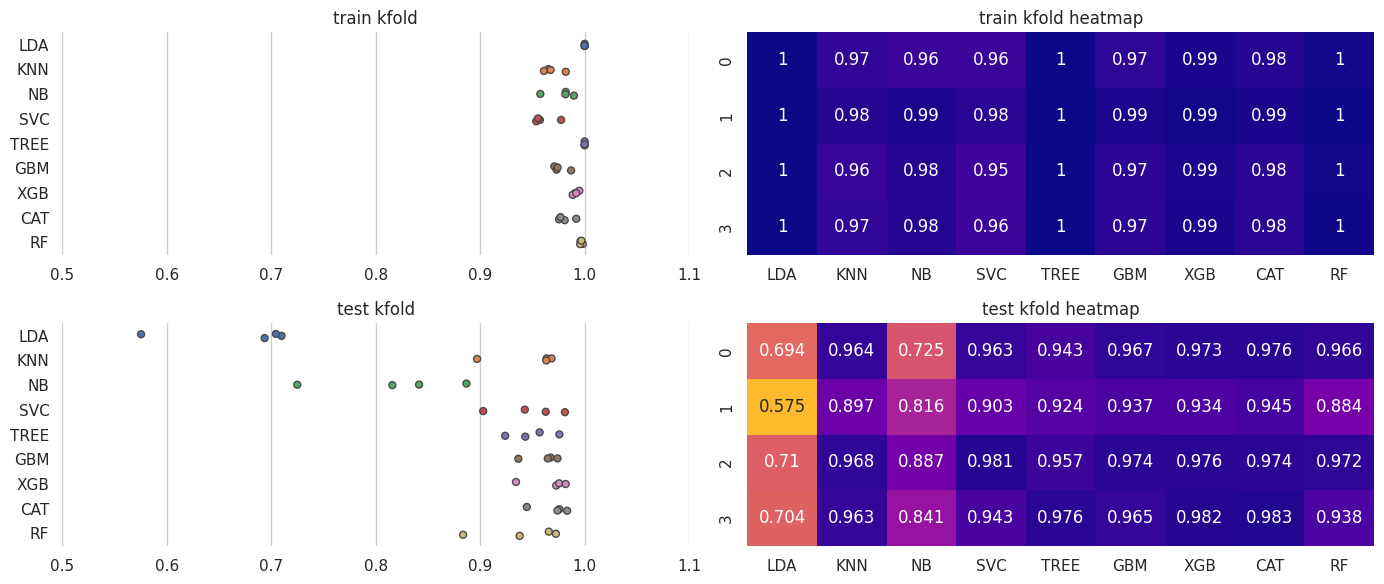

In [41]:
eval1.fold_plot()  # plot kfold results

For predicting ciprofloxacin resistance, the most reliable and consistent models are CatBoost (CAT), XGBoost (XGB), Gradient Boosting (GBM), and Random Forest (RF), all showing high and stable performance across test folds. In contrast, LDA performs poorly with low and unstable test scores, making it unsuitable for this task. Models like Naive Bayes (NB) also show variance between folds, indicating a potential need for hyperparameter tuning or regularization to improve generalization.

**TREE BASED FEATURE IMPORTANCE**

* Using *RandomForest*,*CatBoost*,*XGBRegressor* we have access to the model's relative feature importance
* It's useful to compare the feature importance of multiple models together. We have over 8000 unitigs; let's pick the top 10 most influential.
* The most critical unitigs to the determination of antibiotic resistance (according to the model) are saved in BioPython Seq format & can be used for further analyses.

In [42]:
''' Tree Based Feature Importance '''
# requires evaluation class input w/ at least one of RF, CatBoost & XGB moedls
# models stored in .store_models are required from eval class

class fi:

    def __init__(self,data=None, # evaluation class
                      sort_by='RF', # show most important features
                      max_features=10 # limit unitigs to
                ):

        if(data is None):
            print('Enter Evaluation class w/ CAT,RF,XGB')
        else:
            evals = data
            # check which models are present
            lst_models = list(evals.store_models.keys())
            temp = []
            for i in lst_models:
                if('CAT' in i):
                    temp.append('CAT')
                if('RF' in i):
                    temp.append('RF')
                if('XGB' in i):
                    temp.append('XGB')

            # input contains gscv data
            if('GS' in lst_models[0]):
                self.gs_id = True
            else:
                self.gs_id = False

        self.lst_tree_models = list(set(temp))

        self.evals = data  # evaluation class
        self.lst_Seqs = []  # list of important unitigs
        self.max_features = max_features # show top n features
        self.sort_by = sort_by # sort by particualr model fi, other mods show this index only
        self.abr_feat = False # activate if unitig names are too big for figure

    # Compile all Tree based feature importance results
    def get(self):

        # USL scaling
        min_max_scaler = preprocessing.MinMaxScaler()

        # Recall Model & Get Feature Importance from data class
        # unless gridsearched, all kfolds are the same model

        ii=-1
        # if randomforest models are present
        if('RF' in self.lst_tree_models):

            if(self.gs_id):

                # fold names
                tlst_models = [f'GS_RF_{i}' for i in range(0,self.evals.nfold)]

                # stack all fold results
                for kfold_id in tlst_models:
                    ii+=1
                    rf_model = self.evals.store_models[kfold_id]
                    imp_rf = rf_model.feature_importances_
                    rf_sc = min_max_scaler.fit_transform(imp_rf[:,None])
                    ldf = pd.DataFrame(rf_sc,index=self.evals.X.columns,columns=[kfold_id])
                    if(ii is 0):
                        df = ldf.copy()
                    else:
                        df = pd.concat([df,ldf],axis=1)

            else:

                ii+=1
                rf_model = self.evals.store_models['RF_1']
                imp_rf = rf_model.feature_importances_
                rf_sc = min_max_scaler.fit_transform(imp_rf[:,None])
                ldf = pd.DataFrame(rf_sc,index=self.evals.X.columns,columns=['RF'])
                if(ii is 0):
                    df = ldf.copy()
                else:
                    df = pd.concat([df,ldf],axis=1)

        # if catboost models are present
        if('CAT' in self.lst_tree_models):

            if(self.gs_id):

                # fold names
                tlst_models = [f'GS_CAT_{i}' for i in range(0,self.evals.nfold)]

                # stack all fold results
                for kfold_id in tlst_models:
                    ii+=1
                    cb_model = self.evals.store_models[kfold_id]
                    imp_cb = cb_model.get_feature_importance()
                    cb_sc = min_max_scaler.fit_transform(imp_cb[:,None])
                    ldf = pd.DataFrame(cb_sc,index=self.evals.X.columns,columns=[kfold_id])
                    if(ii is 0):
                        df = ldf.copy()
                    else:
                        df = pd.concat([df,ldf],axis=1)

            else:
                ii+=1
                cb_model = self.evals.store_models['CAT_1']
                imp_cb = cb_model.get_feature_importance()
                cb_sc = min_max_scaler.fit_transform(imp_cb[:,None])
                ldf = pd.DataFrame(cb_sc,index=self.evals.X.columns,columns=['CB'])
                if(ii is 0):
                    df = ldf.copy()
                else:
                    df = pd.concat([df,ldf],axis=1)


        if('XGB' in self.lst_tree_models):

            if(self.gs_id):

                # fold names
                tlst_models = [f'GS_XGB_{i}' for i in range(0,self.evals.nfold)]

                # stack all fold results
                for kfold_id in tlst_models:
                    ii+=1
                    xg_model = self.evals.store_models[kfold_id]
                    imp_xg = xg_model.feature_importances_
                    xg_sc = min_max_scaler.fit_transform(imp_xg[:,None])
                    ldf = pd.DataFrame(xg_sc,index=self.evals.X.columns,columns=[kfold_id])
                    if(ii is 0):
                        df = ldf.copy()
                    else:
                        df = pd.concat([df,ldf],axis=1)

            else:

                ii+=1
                xg_model = self.evals.store_models['XGB_1']
                imp_xg = xg_model.feature_importances_
                xg_sc = min_max_scaler.fit_transform(imp_xg[:,None])
                ldf = pd.DataFrame(rf_sc,index=self.evals.X.columns,columns=['XGB'])

                if(ii is 0):
                    df = ldf.copy()
                else:
                    df = pd.concat([df,ldf],axis=1)

        # change to abbrev if names are too long to display
        if(self.abr_feat):
            self.evals.col_trans(0)

        # Sort by one of the available columns
        df.sort_values(by=self.sort_by,ascending=False,inplace=True)

        if(self.abr_feat):
                self.evals.col_trans(1)

        # show only most critical features in FI
        subset = df[:self.max_features]

#       Store the most important features
        for i in subset.index.tolist():
            self.lst_Seqs.append(Seq(i))

        # Plot features
        fig = px.bar(subset,orientation='h')
        fig.update_traces(width=0.5)
        fig.update_layout(height=400,template='plotly_white',
                          title=f"<b>FEATURE IMPORTANCE</b> | Sorted by {self.sort_by}()")
        fig.show()

In [43]:
crit_unitigs = fi(data=eval1,sort_by='CB')
crit_unitigs.get()

In [44]:
crit_unitigs.lst_Seqs

[Seq('GTGCGACAGCAAAGTCCAAACCAGCGTCCCCGCC'),
 Seq('GCGCAGCCGCAAATCTTGTTTTCCCATTCCGCC'),
 Seq('GACTACATCAGCGGCAACATCTTGTTTATGCTGACCG'),
 Seq('CTCGTCCGAAGTGCAGCACAAAAATCTGATGCAGCAGCAACAGCA'),
 Seq('AAATTGCGGATCGATGCGCGAAGGGTCGAATGC'),
 Seq('CCCTATGGTCAATCATCAATCAGCAGTGGACC'),
 Seq('GCAAATTTACGACGAACCCGAATTCGATCCTCAAGAGCTGCAAT'),
 Seq('ATGCGCCGTACTCGGCACACTTTCCCGTTTGGACACCGTCCG'),
 Seq('ACGGACGCTCTGTTCCGTACCCATCTGCCACGAA'),
 Seq('AGATTGAGCCGAATTTCTGGATTAAGTGCCGG')]

## 6.3. GridSearchCV Resistance Model

**CATBOOST HYPERPARAMETER TUNING**

* We saw that *CatboostClassifier* had already has quite good results on the test set, let's try to optimise the hyperparameters, if we can.
* Catboost does optimise certain parameters that aren't self defined, so we may not get any improvement, however we should get different hyerparameter combinations on different folds, which will be handy to check if there is any feature importance variation.

**GETTING ALL MODELS PARAMETERS**

* We can call `.get_all_params()` to display all the parameters that were set in CatBoost, on top of the n_estimators that we set ourselves.
* The learning rate & n_estimators/iterations are two hyperparameters we can try to tune.

In [45]:
# Show default parameters used in catboost model
eval1.store_models['CAT_0'].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 10,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss

DEFINING GRID & GRIDSEARCHCV

* We define a parameter grid, which will be used in GridSearchCV; keeping it simple, looking at only n_estimators (iters) & the learning rate.
* Defining a standard 4-fold cross validation strategy once again, we should get 4 slightly different models this time, which are stored in .store_models().
* Catboost is of course compatible with the GPU, so we can set task_type = "GPU".

In [ ]:
# Define Grid used in Cross Validation
params = {'n_estimators':[10,25,40],
         'learning_rate':[0.01,0.05,0.5]}

# Define Model (just the one)
models = []
models.append(('CAT', CatBoostClassifier(silent=True,
                                         task_type="GPU"),params))

# Get Dataset Features
case2 = get_unitigs()
case2.get_case('cip_sr')

eval2 = class_eval(data=case,
                   models=models)
eval2.gscv()